# DS Foundations Project Status Assessment 

### Exploring Tennessee In School Suspension Data

By: Lawand Yaseen 

In [44]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

import sklearn.metrics as m

from sklearn.pipeline import Pipeline

#DATAFRAME AND VIZ CODE FOR PRESENTATION 
data = pd.read_csv("/Users/lawandyaseen/Desktop/PPOL564FinalProject/Suspension_TeachExp_Finance.csv")
data = data.drop(columns = ["Unnamed: 0"])

#viz1 draft
viz1 = data

#creating ggplot viz
viz1_plot = ggplot(viz1, aes(x = "ALL STUDENTS", y ="ECONOMICALLY DISADVANTAGED")) + geom_point() + theme_classic() + facet_wrap(["SCHOOL_LEVEL_PER_PUPIL_QUARTILE"])

#adding labels
viz1_plot = viz1_plot + labs(x = "Percent of Students Suspended", y = "Percent of Economically Disadvantaged Students Suspended", title = "Per Student Funding Effect on ISS")

#viz2 subsetting data
viz2 = data.sort_values(by = "ECONOMICALLY DISADVANTAGED", ascending = False)
viz2 = viz2[:50]

#creating plot object
viz2_plot = (ggplot(viz2, aes(x = "SCHOOL_NAME", y = "SCHOOL_LEVEL_PER_PUPIL_QUARTILE")) + geom_tile() + guides(fill = False) + theme(axis_text_x = element_text(angle = 90, hjust = 1)))
viz2_plot = viz2_plot + labs(x = "School", y = "Funding Quartile", title = "Per Student Funding Comparison Among Highest ISS Rates in Econ. Disad. Students") 

In [60]:
#setting seed 
np.random.seed(1234)


#separating outcome and predictors
#outcome -- all students
Y = data['ALL STUDENTS']
#predictors of interest
X = data[['BLACK', 'ECONOMICALLY DISADVANTAGED', 'MALE', 'BHNA', 'TEACH_EXP', 'TEACH_EMERG', 'TEACH_OUT_OF_FIELD', 'SCHOOL_LEVEL_PER_PUPIL']]
#economically disadvantaged, black, white, per pupil spending, teacher experience, teacher emergency, teacher out of field


#split data into training and test
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=.2,random_state=1234)

#scale of spending --- thousands, other categories are between 0-100


#Using SKLEARN from class
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)
use_metrics = ["neg_mean_squared_error"]

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BLACK', 'ECONOMICALLY DISADVANTAGED', 'MALE', 'BHNA', 'TEACH_EXP', 'TEACH_EMERG', 'TEACH_OUT_OF_FIELD', 'SCHOOL_LEVEL_PER_PUPIL'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters.
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},

    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},

    # The Bagging decision tree model
    {'model': [Bag()]},

    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)
# (6) Fit the model to the training data
search.fit(train_X,train_Y)



search.best_score_ # Mean out-of-sample (CV) error


search.best_params_
#need to tune the parameter



#pulling model scores for comparison 
lm_scores = cross_validate(LM(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)
knn_scores = cross_validate(KNN(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)
dt_scores = cross_validate(DTree(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)
bag_scores = cross_validate(Bag(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)
rf_scores = cross_validate(RF(),train_X,train_Y, cv = fold_generator, scoring =use_metrics)

# Collect all the metrics we care about as a dictionary 
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores.head()


#predict will use best model
pred_Y = search.predict(test_X)

viz3_plot = (
    ggplot(pd.DataFrame(dict(pred=pred_Y,truth=test_Y)),
          aes(x='pred',y="truth")) + labs(x = "Predicted ISS Rate", y = "Real ISS Rate", title = "Accuracy of ML Model") +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="blue",size=1) +
    theme_classic() +
    theme(figure_size=(9,7))
)


#model comparison 

## Recent Legislative Activity

### School to Prison Pipeline 
   - Black students and students with disabilities are more likely to recieve harsher discipline
   - Student who have been suspended are twice as likely to be involved in the criminal justice system
   - In TN: 91,000 students were suspended at least once during the 2017-2018 AY  
    
### Tennessee Discipline Act 
   - Legislation enacted on April 6, 2021: Allows teachers to initiate in school suspension (ISS) process 
       - "*Creates a uniform referral process allowing teachers to petition a removal of a student who repeatedly or substantially interferes with classroom learning*."
   - **Perception**: improving student behavior and classroom experience universally 


## Proposed Analysis
  - Exploring any potential relationships between ISS rate and student demographics, teacher experience and per student spending 

**Question of Interest**: Are there tangible predictors within the aformentioned categories that predict a student's likelihood to be in ISS? For schools with notable volume in these variables, can we externally identify any more context that would cause such increase?

## Data Collection 

- Publicly available data from the TN Department of Education reported at the school level 
    - 2019-2020 data was interrupted by COVID-19 pandemic: use of 2018-2019 most complete 

#### Datasets

- *Discipline*: suspension rates by demographic, SES, and other relevent subsets 
- *Teacher Licensure*: percentage of teachers classified as experienced, in field, emergency 
- *Finance*: dollar amount of finances spent per student

## Methodology Creation

- Discipline is provided in a district-school-demographic format 
    - conducive to visualization processing but will be more difficult to use for ML 
  - similar situation for teacher licensure

- Visual assessment of data: *lots of NA's and 0's*
    - representative of a **lack of students** from subsets present at schools 
        - will present challenges for the ML aspects

## Methodology Creation (cont.)

- Naive Bayes Classifier: unlikely to be used as binary outcome is not of interest 
- Linear Regression: not useful given composition of predictor variables 
    - likely initial approach: **Using SKLEARN API to compare various ML models to predict suspension**
    
- Given the simplicity of data collection, interest in outlier schools' context 
    - Examples: clusters of location, attendance rates, local crime spike

## Methodology Used 

- Transformed and merged data based on school 
    - demographic variables separated into columns 
    - per student spending divided into 4 quartiles 
        - dummy variables specifying **school's spending in relation to peers** 

In [47]:
data.head()

,SCHOOL_NAME,ALL STUDENTS,ASIAN,BLACK,BHNA,ECONOMICALLY DISADVANTAGED,ELA,FEMALE,HISPANIC,MALE,...,TEACH_EMERG,TEACH_NOT_EMERG,TEACH_OUT_OF_FIELD,TEACH_IN_FIELD,SCHOOL_LEVEL_PER_PUPIL,SCHOOL_LEVEL_PER_PUPIL_QUARTILE,0-25 %,25-50 %,50-75 %,75-100 %
0,Anderson County High School,5.0,0.0,6.7,3.3,10.9,0.0,3.4,0.0,6.5,...,0.0,100.0,0.0,100.0,5546.155493,0-25 %,1,0,0,0
1,Andersonville Elementary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,6696.478548,25-50 %,0,1,0,0
2,Briceville Elementary,3.8,0.0,0.0,0.0,5.1,0.0,0.0,0.0,7.8,...,0.0,100.0,0.0,100.0,9289.358974,75-100 %,0,0,0,1
3,Claxton Elementary,1.1,0.0,0.0,1.8,1.7,0.0,0.0,0.0,2.1,...,0.0,100.0,0.0,100.0,7419.320455,50-75 %,0,0,1,0
4,Clinton Middle School,13.6,0.0,23.3,14.5,21.5,0.0,6.6,0.0,20.8,...,0.0,100.0,0.0,100.0,5940.561747,0-25 %,1,0,0,0


## ML Methodology Exploration 

- split dataset into 80% training, 20% test 
    - 1321 schools used in training set 
- efficient model comparsion performed using SKLEARN 
    - runs 5 different iterations of ML models: Linear, KNN, Decision Tree, Bagging and Random Forest 
    - can return the model with the least MSE 
- model results shown in table below: best model is linear regression 

In [64]:
collect_scores.head()

,Model,MSE
0,lm,0.830051
1,lm,0.849882
2,lm,1.137748
3,lm,1.576449
4,lm,1.124673


## Preliminary Results

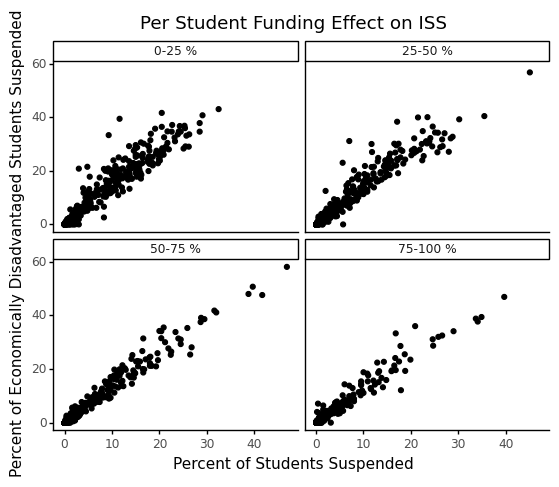

<ggplot: (8787891516410)>

In [67]:
viz1_plot

## Visualizing Funding Subset in High Risk Schools

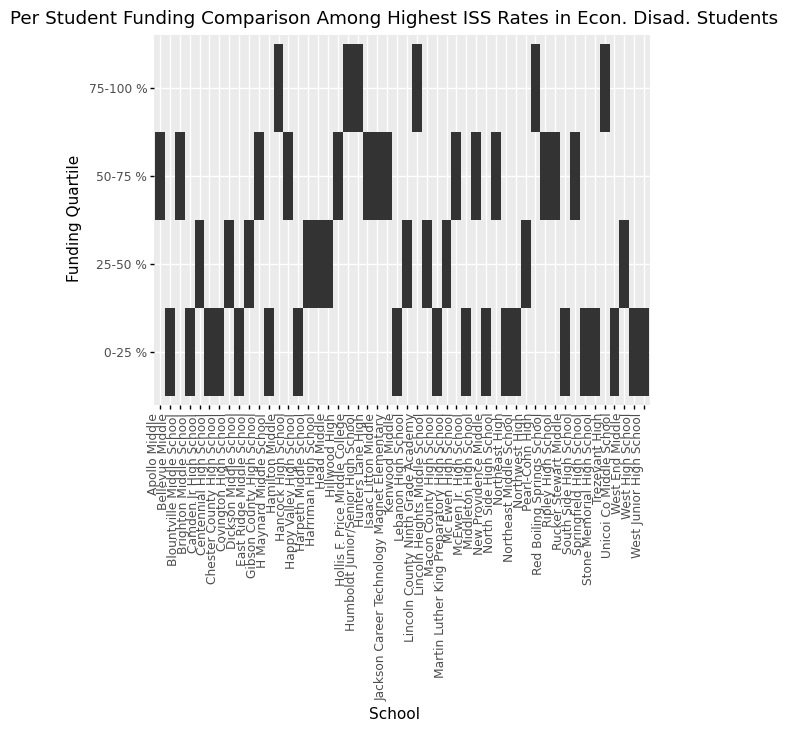

<ggplot: (8787892036590)>

In [68]:
viz2_plot

## Graphical Representation of Model Accuracy 

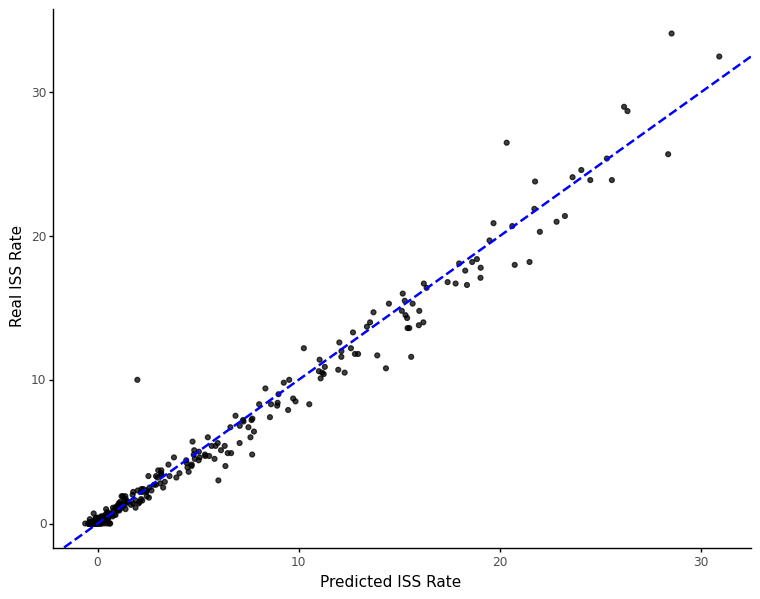

<ggplot: (8787892279911)>

In [69]:
viz3

## Lessons Learned, Future Plans + Problems

- Current ML model is weak 
    - Artificially more accurate due to significant number of schools with 0's for real values 
    - Middle & HS suspensions might be more likely to occur so could be useful to exclude elementary schools 
    
- Commonalities among schools with very high ISS rates 
    - Come from urban/suburban communities: Memphis, Jackson, Nashville 
    - High and Middle schools **dominate** top 50 of economically disadvanged ISS rates 
    
- Future Plans 
    - *Improve Viz's*: Explore demographic variables effect on ISS rates in more detail 
    - Tune parameters of ML 
    - Run partial dependency plots to evaluate most effective parameters on ISS outcome
